# Modelos para probabilidad de respuesta

Importamos librerías:

In [98]:
# Librerías generales
import os
import numpy as np
import pandas as pd
# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Modelos
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Regresión logística
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix
from ISLP.models import (ModelSpec,
                         Stepwise,
                         sklearn_selected)

# Selección de variables
from ISLP.models import (Stepwise,sklearn_selected)  # Para selección de variables (ISLP)
from sklearn.feature_selection import SequentialFeatureSelector # Selección de variables (CV)
import contextlib

Seteamos el directorio de trabajo:

In [2]:
os.chdir('C:/Users/celin/OneDrive/Documentos/CELINE/FACULTAD/Maestría en Estadística Aplicada/4to semestre/Tesis/Nonresponse-bias-eph')

Cargamos la base de datos individual (filtrada por el jefe de hogar, para tomar un registro por hogar):

In [3]:
# Cargamos las bases de datos
individual_NEA = pd.read_csv("Bases/individual_NEA_paramodelos.txt", sep=";", low_memory=False)
individual_NEA.head()

,ANO4,TRIMESTRE,CODUSU,NRO_HOGAR,periodo,AGLOMERADO,REGION_DESC,REGION_COD,CH04,CH06,...,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9,viviendasxarea
0,2017,2,TQRMNOPPQHJMKRCDEFOCD00472238,1,2017.25,8,Noreste,41,1,62,...,2.0,2.0,2.0,0.0,2.0,0.0,1.0,2.0,1.0,7
1,2017,2,TQRMNOPPQHKMLMCDEGLDF00590955,1,2017.25,15,Noreste,41,2,48,...,1.0,2.0,2.0,0.0,2.0,0.0,3.0,2.0,1.0,3
2,2017,2,TQRMNOPPQHKMLQCDEFOCD00472357,1,2017.25,8,Noreste,41,1,39,...,1.0,1.0,2.0,0.0,2.0,0.0,1.0,2.0,1.0,7
3,2017,2,TQRMNOPPQHKOKOCDEGIBJ00509386,1,2017.25,12,Noreste,41,1,34,...,2.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,9
4,2017,2,TQRMNOPPRHJMKRCDEFOCD00472239,1,2017.25,8,Noreste,41,1,33,...,1.0,2.0,2.0,0.0,2.0,0.0,1.0,2.0,1.0,7


In [4]:
# Dimensión de la base
print("Dimensión de la base total: ", individual_NEA.shape)

Dimensión de la base total:  (36172, 259)


Filtramos por la última entrevista registrada de cada hogar, para no duplicar:

In [5]:
# Filtramos por última entrevista
ult_entrevista = individual_NEA.groupby(['CODUSU','NRO_HOGAR'])['n_entrevista'].idxmax()
individual_NEA = individual_NEA.loc[ult_entrevista].reset_index(drop=True)
# Cantidad de registros
print("Dimensión de la base filtrada: ", individual_NEA.shape)

Dimensión de la base filtrada:  (15814, 259)


In [6]:
# Variables para el modelo
variables = [
    'completo',  # Variable de respuesta
    # Variables de identificación del hogar
    'AGLO_DESC', 'periodo', 'PONDERA_repr', 'viviendasxarea',
    # Ingreso del hogar
    'IPCF_d', 'otros_ing_nolab', 'RDECOCUR', 'ADECOCUR',
    # Datos del jefe de hogar
    'CH06', 'CH06_2', 'IX_TOT', 'informal', 'NIVEL_ED', 'mujer', 'casadounido', 'ESTADO', 'CAT_INAC', 'CAT_OCUP',
    # Características de la vivienda
    'IV1', 'IV2', 'IV3', 'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11', 'IV12_1', 'IV12_2', 'IV12_3',
    # Características habitacionales del hogar
    'II1', 'II2', 'II3', 'II3_1', 'II4_1', 'II4_2', 'II4_3', 'II5', 'II6', 'II6_1', 'II7', 'II8', 'II9',
    # Ocupación del jefe de hogar
    #'CALIFICACION', 'JERARQUIA', 'caes_seccion_cod', 'PP04B1',
    # Características de composición del hogar
    'cantidad_varones', 'cantidad_mujeres', 'cantidad_ocupados','cantidad_desocupados', 'cantidad_informales', 'edad_promedio_hogar'
]

# Seleccionamos estos campos en la base de datos
individual_NEA = individual_NEA[variables]

# Estratos para división
individual_NEA['estrato'] = (
    individual_NEA['completo'].astype(str) + '_' +
    individual_NEA['periodo'].astype(str)
)

Convertimos las variables tipo string a categóricas y luego a dummies:

In [8]:
# Convertimos en categóricas las variables tipo object
for col in individual_NEA.select_dtypes(include='object').columns:
    individual_NEA[col] = individual_NEA[col].astype('category')
# Convertimos en dummies las variables categóricas
individual_NEA = pd.get_dummies(individual_NEA, columns=['CALIFICACION','JERARQUIA','caes_seccion_cod','PP04B1'], dtype=int)
# Eliminamos dummies de "No ocupado"
individual_NEA = individual_NEA.drop(
    columns=[
        'CALIFICACION_No ocupado',
        'CALIFICACION_N/s',
        'JERARQUIA_Ns.Nc',
        'JERARQUIA_No ocupado',
        'caes_seccion_cod_No ocupado',
        'PP04B1_No ocupado',
        'PP04B1_No presta',
        'RDECOCUR'
    ])


KeyError: "None of [Index(['CALIFICACION', 'JERARQUIA', 'caes_seccion_cod', 'PP04B1'], dtype='object')] are in the [columns]"

In [9]:
# Dummies de nivel educativo
individual_NEA = pd.get_dummies(individual_NEA, columns=['NIVEL_ED'], drop_first=True, dtype=int)

ESTADO: Condición de actividad
* 0 = Entrevista individual no realizada (no respuesta al cuestionario 
individual) 
* 1 = Ocupado 
* 2 = Desocupado 
* 3 = Inactivo 
* 4 = Menor de 10 años

CAT_OCUP: Categoría ocupacional (Para ocupados y desocupados con ocupación anterior) 
* 1 = Patrón 
* 2 = Cuenta propia 
* 3 = Obrero o empleado 
* 4 = Trabajador familiar sin remuneración 
* 9 = Ns/Nr

In [10]:
for col in ['ESTADO','CAT_OCUP','CAT_INAC']:
    individual_NEA[col] = individual_NEA[col].astype('category')
individual_NEA = pd.get_dummies(individual_NEA, columns=['ESTADO','CAT_OCUP','CAT_INAC'], drop_first=True, dtype=int)

Borramos un par de registros que están mal (controlar esto):

In [11]:
print('Dimensión de la base (antes): ', individual_NEA.shape)
individual_NEA = individual_NEA[
    ~(
        (individual_NEA['completo'] == 1) &
        (individual_NEA['periodo'] == 2019.75) &
        (individual_NEA['AGLO_DESC'] == 'Gran Resistencia')
    )
]

individual_NEA = individual_NEA[
    ~(
        (individual_NEA['completo'] == 1) &
        (individual_NEA['periodo'] == 2020.75) &
        (individual_NEA['AGLO_DESC'] == 'Gran Resistencia')
    )
]
print('Dimensión de la base (después): ', individual_NEA.shape)

Dimensión de la base (antes):  (15814, 65)
Dimensión de la base (después):  (15812, 65)


In [12]:
print('Dimensión de la base (antes): ', individual_NEA.shape)
individual_NEA = individual_NEA.dropna()
print('Dimensión de la base (después): ', individual_NEA.shape)

Dimensión de la base (antes):  (15812, 65)
Dimensión de la base (después):  (15810, 65)


Definimos los vectores y, x y estrato para la división en entrenamiento y test:

In [13]:
# respuesta de los modelos
y_R = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Gran Resistencia']['completo'])
y_C = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Corrientes']['completo'])
y_F = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Formosa']['completo'])
y_P = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Posadas']['completo'])
# Matriz del modelo
X_R = individual_NEA[individual_NEA['AGLO_DESC']=='Gran Resistencia'].drop(columns=['completo','estrato','AGLO_DESC'])
X_C = individual_NEA[individual_NEA['AGLO_DESC']=='Corrientes'].drop(columns=['completo','estrato','AGLO_DESC'])
X_F = individual_NEA[individual_NEA['AGLO_DESC']=='Formosa'].drop(columns=['completo','estrato','AGLO_DESC'])
X_P = individual_NEA[individual_NEA['AGLO_DESC']=='Posadas'].drop(columns=['completo','estrato','AGLO_DESC'])
# Variables para estratificar
estrato_R = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Gran Resistencia']['estrato'])
estrato_C = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Corrientes']['estrato'])
estrato_F = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Formosa']['estrato'])
estrato_P = np.array(individual_NEA[individual_NEA['AGLO_DESC']=='Posadas']['estrato'])

División en entrenamiento y test, dividimos internamente:

In [14]:
X_R_train, X_R_test, y_R_train, y_R_test = train_test_split(X_R, y_R, test_size=0.2, stratify=estrato_R) # Gran Resistencia
X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(X_C, y_C, test_size=0.2, stratify=estrato_C) # Corrientes
X_F_train, X_F_test, y_F_train, y_F_test = train_test_split(X_F, y_F, test_size=0.2, stratify=estrato_F) # Formosa
X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P, y_P, test_size=0.2, stratify=estrato_P) # Posadas

Revisar casos con NAs en las variables regresoras:

## Modelo de regresión logístico

 Realizamos selección de variables usando stepwise forward selection para el modelo logístico (escalamos variables previamente):

In [15]:
def negAIC(estimator, X, Y):
    "Negative AIC"
    n, p = X.shape
    Yhat = estimator.predict(X)
    MSE = np.mean((Y - Yhat)**2)
    return n + n * np.log(MSE) + 2 * (p + 1)

def drop_singular_cols(X):
    # Rangos
    rank = np.linalg.matrix_rank(X)
    while rank < X.shape[1]:
        # Calcular correlación perfecta
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [col for col in upper.columns if any(upper[col] == 1)]
        if not to_drop:
            break
        X = X.drop(columns=[to_drop[0]])
    return X.drop(columns='const', errors='ignore')

In [16]:
# Diccionario con los datasets
datasets = {
    "Resistencia": (X_R_train, y_R_train),
    "Corrientes": (X_C_train, y_C_train),
    "Formosa": (X_F_train, y_F_train),
    "Posadas": (X_P_train, y_P_train)
}

# Matrices de diseño
print('Matrices de diseño. Cálculo.')
designs = {}
for aglo, (X_train, y_train) in datasets.items():
    design = ModelSpec(X_train.columns).fit(X_train)
    X_train = design.transform(X_train)
    designs[aglo] = design
    datasets[aglo] = (X_train, y_train)
    print(f"✅ Matriz de diseño para {aglo}")

Matrices de diseño. Cálculo.
✅ Matriz de diseño para Resistencia
✅ Matriz de diseño para Corrientes
✅ Matriz de diseño para Formosa
✅ Matriz de diseño para Posadas


In [17]:
X_train

,intercept,periodo,PONDERA_repr,viviendasxarea,IPCF_d,otros_ing_nolab,RDECOCUR,ADECOCUR,CH06,CH06_2,...,CAT_OCUP_1,CAT_OCUP_2,CAT_OCUP_3,CAT_OCUP_4,CAT_INAC_1,CAT_INAC_2,CAT_INAC_3,CAT_INAC_4,CAT_INAC_6,CAT_INAC_7
319,1.0,2017.25,222.333333,14,3599.361065,4350.0,0,0,61,3721,...,0,1,0,0,0,0,0,0,0,0
10742,1.0,2023.25,223.750000,5,3168.064451,58000.0,0,0,72,5184,...,0,0,0,0,1,0,0,0,0,0
8082,1.0,2023.50,320.923077,9,9205.308689,0.0,6,6,24,576,...,0,0,1,0,0,0,0,0,0,0
4632,1.0,2022.25,210.333333,10,9263.117578,0.0,9,8,39,1521,...,0,0,1,0,0,0,0,0,0,0
14390,1.0,2023.50,331.000000,1,9268.503028,0.0,6,5,37,1369,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9066,1.0,2020.50,304.000000,9,3453.945631,0.0,2,2,59,3481,...,0,1,0,0,0,0,0,0,0,0
14285,1.0,2023.25,369.000000,3,4369.744070,80000.0,0,0,21,441,...,0,0,1,0,0,0,0,0,0,0
7978,1.0,2017.25,223.800000,10,8274.393254,0.0,10,10,62,3844,...,0,0,1,0,0,0,0,0,0,0
10235,1.0,2019.50,279.736842,16,9083.058361,0.0,10,10,45,2025,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Diccionario para modelos ajustados
modelos = {}

# Stepwise
for aglo, (X_train, y_train) in datasets.items():
    
    # Establecemos estrategia
    print(f'Trabajando con {aglo}...')    
    design = designs[aglo]
    strategy = Stepwise.first_peak(
        design, 
        direction='forward',
        max_terms=len(design.terms)
    )

    # Corremos stepwise
    #modelo_LR = LogisticRegression(class_weight='balanced')
    modelo = sklearn_selected(
        sm.Logit,
        strategy,
        scoring=negAIC
    )
    print(f"✅ Stepwise para {aglo}")

    # Ajustamos el modelo
    with contextlib.redirect_stdout(None):
        modelo.fit(X_train, y_train, disp=0)
        modelos[aglo] = modelo 
    print(f"✅ Modelo ajustado para {aglo}")

Trabajando con Resistencia...
✅ Stepwise para Resistencia


NameError: name 'contextlib' is not defined

In [ ]:
# Definimos el modelo base
def build_model():
    return make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced')
    )

# Diccionario con los datasets
datasets_train = {
    "Resistencia": (X_R_train, y_R_train),
    "Corrientes": (X_C_train, y_C_train),
    "Formosa": (X_F_train, y_F_train),
    "Posadas": (X_P_train, y_P_train)
}

# Entrenar un modelo SFS por cada dataset
modelos_sfs = {}
for aglo, (X_train, y_train) in datasets.items():
    modelo = build_model()
    sfs = SequentialFeatureSelector(modelo, direction='forward')
    sfs.fit(X_train, y_train)
    modelos_sfs[aglo] = sfs
    print(f"✅ Modelo entrenado para {aglo}")

✅ Modelo entrenado para Resistencia
✅ Modelo entrenado para Corrientes
✅ Modelo entrenado para Formosa
✅ Modelo entrenado para Posadas


In [61]:
# Diccionario para guardar las columnas seleccionadas por cada modelo
features_seleccionadas = {}

for aglo, selector in modelos_sfs.items():
    # Tomamos cualquier X_train correspondiente para obtener los nombres de columnas
    X_train, _ = datasets_train[aglo]
    
    # Transformamos para obtener columnas seleccionadas (mask booleana)
    mask = selector.get_support()  # True si la columna fue seleccionada
    cols_seleccionadas = X_train.columns[mask]
    
    features_seleccionadas[aglo] = list(cols_seleccionadas)

# Mostrar resultados
for aglo, cols in features_seleccionadas.items():
    print(f"{aglo}: {cols}")


Resistencia: ['otros_ing_nolab', 'IV3', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV12_1', 'IV12_2', 'IV12_3', 'II1', 'II3_1', 'II4_1', 'II5', 'II6', 'II6_1', 'II8', 'II9', 'cantidad_ocupados', 'cantidad_desocupados', 'NIVEL_ED_Secundario completo', 'NIVEL_ED_Secundario incompleto', 'ESTADO_2', 'CAT_OCUP_1', 'CAT_OCUP_4', 'CAT_INAC_2', 'CAT_INAC_3', 'CAT_INAC_4', 'CAT_INAC_6', 'CAT_INAC_7']
Corrientes: ['periodo', 'IPCF_d', 'IX_TOT', 'informal', 'casadounido', 'IV1', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11', 'IV12_1', 'IV12_3', 'II3', 'II3_1', 'II4_1', 'II4_3', 'II5', 'II6', 'II6_1', 'II7', 'II8', 'II9', 'edad_promedio_hogar', 'ESTADO_2', 'CAT_OCUP_4', 'CAT_INAC_2', 'CAT_INAC_4', 'CAT_INAC_6', 'CAT_INAC_7']
Formosa: ['viviendasxarea', 'IPCF_d', 'otros_ing_nolab', 'CH06_2', 'casadounido', 'IV4', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV12_1', 'IV12_2', 'IV12_3', 'II2', 'II4_1', 'II6_1', 'II7', 'II8', 'II9', 'cantidad_varones', 'cantidad_desocupados', 'edad_promedio_hogar', 'NIVEL_ED_U

In [84]:
modelos_logit = {}
for aglo, (X_train, y_train) in datasets_train.items():
    # Selecciona las columnas usando el selector correspondiente
    selected_features = modelos_sfs[aglo]  # tu selector
    X_train_selected = selected_features.transform(X_train)
    # Ajustar modelo
    modelo_logit = LogisticRegression(verbose=1, class_weight='balanced')
    modelo_logit.fit(X_train_selected, y_train)
    # Guardar modelo ajustado
    modelos_logit[aglo] = modelo_logit

C:\Users\celin\anaconda3\envs\islp\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\celin\anaconda3\envs\islp\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

In [85]:
# Función para calcular métricas
def calcular_metricas(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:,1] if hasattr(modelo, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    sens = recall_score(y_test, y_pred, pos_label=1)   # Sensibilidad
    esp = recall_score(y_test, y_pred, pos_label=0)    # Especificidad
    vpp = precision_score(y_test, y_pred, pos_label=1) # Valor Predictivo Positivo
    vpn = precision_score(y_test, y_pred, pos_label=0) # Valor Predictivo Negativo
    
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    return {
        "accuracy": round(acc,5),
        "sensibilidad": round(sens,5),
        "especificidad": round(esp,5),
        "VPP": round(vpp,5),
        "VPN": round(vpn,5),
        "auc": round(auc,5) if auc is not None else None
    }

# Diccionario con datasets de train/test
datasets = {
    "Resistencia": (X_R_train, X_R_test, y_R_train, y_R_test),
    "Corrientes": (X_C_train, X_C_test, y_C_train, y_C_test),
    "Formosa": (X_F_train, X_F_test, y_F_train, y_F_test),
    "Posadas": (X_P_train, X_P_test, y_P_train, y_P_test)
}

In [92]:
# DataFrame vacío para guardar resultados
resultados = pd.DataFrame()

# Entrenamos y evaluamos
for aglo, (X_train, X_test, y_train, y_test) in datasets.items():
    # Modelo seleccionado
    modelo = modelos_logit[aglo]
    # Variables seleccionadas
    selected_features = modelos_sfs[aglo]  # tu selector
    X_test_selected = selected_features.transform(X_test)
    # Calculamos métricas de clasificación
    metricas = calcular_metricas(modelo, X_test_selected, y_test)
    metricas["Modelo"] = "Logistic Regression"
    metricas["Aglomerado"] = aglo
    print(f"✅ Métricas calculadas para {aglo}")

    # Probabilidad promedio estimada
    probs = modelo.predict_proba(X_test_selected)[:,1] if hasattr(modelo, "predict_proba") else None
    prob_promedio = probs.mean()
    metricas['prob_mean'] = prob_promedio

    # Concatenamos resultados
    resultados = pd.concat([resultados, pd.DataFrame([metricas])], ignore_index=True)

✅ Métricas calculadas para Resistencia
✅ Métricas calculadas para Corrientes
✅ Métricas calculadas para Formosa
✅ Métricas calculadas para Posadas


In [93]:
print(resultados)

   accuracy  sensibilidad  especificidad      VPP      VPN      auc  \
0   0.64205       0.48276        0.69907  0.36482  0.79058  0.62295   
1   0.61066       0.69337        0.52973  0.59059  0.63844  0.66363   
2   0.60199       0.58961        0.61337  0.58355  0.61928  0.62328   
3   0.66176       0.76524        0.51148  0.69467  0.60000  0.63819   

                Modelo   Aglomerado  prob_mean  
0  Logistic Regression  Resistencia   0.493561  
1  Logistic Regression   Corrientes   0.507459  
2  Logistic Regression      Formosa   0.497294  
3  Logistic Regression      Posadas   0.505301  


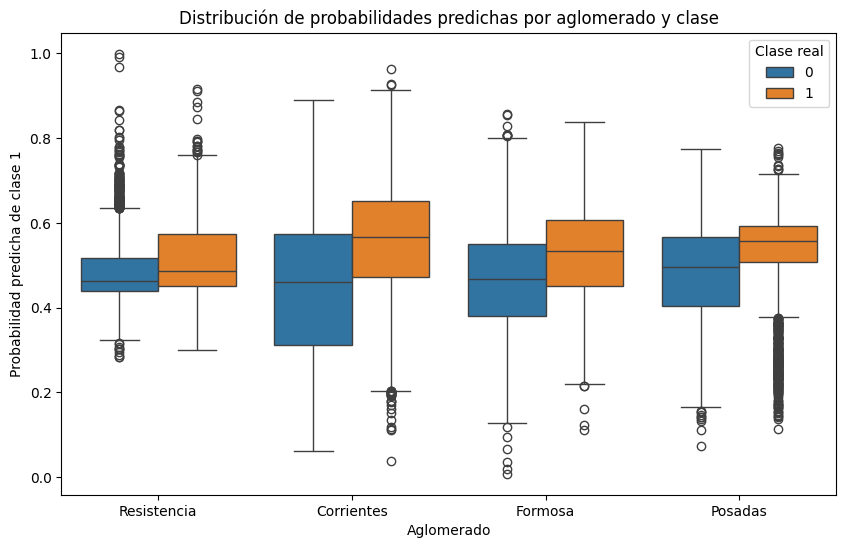

In [100]:
# Concatenamos train + test para cada aglomerado
df_predicciones = pd.DataFrame()

for aglo, (X_train, X_test, y_train, y_test) in datasets.items():
    # Modelo
    modelo = modelos_logit[aglo]
    # Selector de features
    selector = modelos_sfs[aglo]
    
    # Concatenamos X y y
    X_total = pd.concat([X_train, X_test], ignore_index=True)
    y_total = pd.concat([pd.Series(y_train), pd.Series(y_test)], ignore_index=True)
    
    # Seleccionamos las columnas
    X_total_selected = selector.transform(X_total)
    
    # Predicciones
    if hasattr(modelo, "predict_proba"):
        probs = modelo.predict_proba(X_total_selected)[:,1]
    else:
        probs = modelo.predict(X_total_selected)
    
    # Guardamos en un DataFrame
    df_temp = pd.DataFrame({
        "Aglomerado": aglo,
        "y_real": y_total,
        "Prob_pred": probs
    })
    
    df_predicciones = pd.concat([df_predicciones, df_temp], ignore_index=True)

# Boxplot: probabilidad predicha por clase y aglomerado
plt.figure(figsize=(10,6))
sns.boxplot(x="Aglomerado", y="Prob_pred", hue="y_real", data=df_predicciones)
plt.title("Distribución de probabilidades predichas por aglomerado y clase")
plt.ylabel("Probabilidad predicha de clase 1")
plt.xlabel("Aglomerado")
plt.legend(title="Clase real")
plt.show()


Agregar que el estratificado incluya periodo y aglomerado también.